introduction: 
I have always wondered whether 'quantity over quality' holds true when it comes to social relationships. I’ve always believed that when someone has many close friends, they tend to "diversify" their time and emotions across a larger group, which can result in weaker individual connections and, consequently, lower emotional security.

Given this dataset, I first decided to address this question: Is there a positive linear relationship between the number of close friends and the emotional support an individual receives? In other words, do highly sociable individuals with a large number of close friends feel more emotionally secure and supported during difficult times, or do those with fewer close friends experience greater emotional security?

Hence, I decide to use the following variables to determine the above relationship:

1. CONNECTION_social_num_close_friends_grouped 
(from the question 'How many close friends do you have?')

Description: This variable represents how many close friends an individual has.

Since the data is already grouped into bins in the MC choices, I decide to use a histogram to present the data. 

Data:
3-4: 285 
5 or more: 280
1-2: 198
None: 49
NaN: 38

1. CONNECTION_social_num_close_friends_grouped 
(from the question 'How many close friends do you have?')

Description: This variable represents how many close friends an individual has.

Since the data is already grouped into bins in the MC choices, I decide to use a bar plot to present the data. 

2. PSYCH_attachment_style_questionnaire_secure_confident 
(from the question 'Please respond to the following items using the scale provided - I feel confident that other people will be there for me when I need them')

Description: This variable assesses how confident individuals feel that others will be there for them when needed, measured through a questionnaire. 

------------------

SO... final question:
How does the number of close friends affect an individual's confidence in the availability of social support from others?

Null Hypothesis (H0): There is no significant relationship between the number of close friends and confidence in social support.

Alternative Hypothesis (H1): There is a significant relationship between the number of close friends and confidence in social support, suggesting that an increase in close friends leads to increased confidence in social support up to a certain point.


I will bootstrap the samples due to a small sample size.



/tmp/ipykernel_53/1927476128.py:64: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_53/1927476128.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


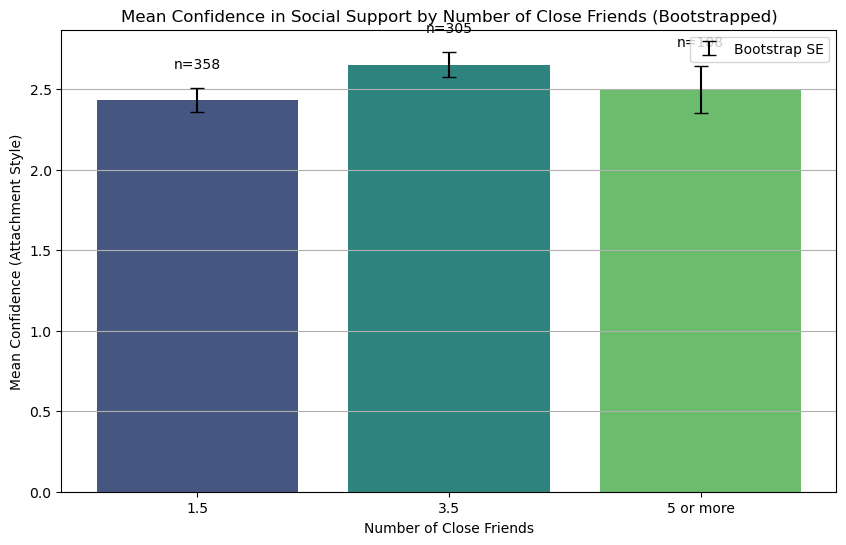

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
url = 'https://github.com/pointOfive/stat130chat130/blob/main/CP/CSCS_data_anon.csv?raw=true'
data = pd.read_csv(url, low_memory=False)

# Function to convert close friends string values to numeric
def convert_close_friends(value):
    if pd.isna(value):
        return np.nan
    if 'or more' in value:
        return 5  # Assuming '5 or more' translates to 5
    elif 'Presented but no response' in value:
        return np.nan  # Treating as missing
    else:
        parts = value.split('–')
        return np.mean([int(parts[0]), int(parts[1])]) if len(parts) > 1 else int(parts[0])

# Apply the conversion function to the relevant column
data['close_friends_num'] = data['CONNECTION_social_num_close_friends_grouped'].apply(convert_close_friends)

# Mapping for attachment style questionnaire
attachment_style_map = {
    'Totally agree': 5,
    'Somewhat agree': 4,
    'Somewhat disagree': 2,
    'Disagree': 1,
    'Totally disagree': 0
}

# Convert the attachment style responses to numeric values
data['attachment_style_num'] = data['PSYCH_attachment_style_questionnaire_secure_confident'].map(attachment_style_map)

# Remove rows with missing values in the relevant columns
data_clean = data.dropna(subset=['close_friends_num', 'attachment_style_num'])

# Perform bootstrapping to estimate mean and standard error for each group
bootstrap_samples = 1000
bootstrapped_stats = []

for group, group_data in data_clean.groupby('close_friends_num'):
    bootstrap_means = []
    for _ in range(bootstrap_samples):
        sample = group_data['attachment_style_num'].sample(frac=1, replace=True)
        bootstrap_means.append(sample.mean())
    bootstrapped_stats.append({
        'close_friends_num': group,
        'bootstrap_mean': np.mean(bootstrap_means),
        'bootstrap_se': np.std(bootstrap_means),  # Standard error from bootstrap
        'count': len(group_data)
    })

# Convert results to a DataFrame
bootstrapped_stats = pd.DataFrame(bootstrapped_stats)

# Replace numeric labels in bootstrapped stats for readability
bootstrapped_stats['close_friends_num'] = bootstrapped_stats['close_friends_num'].replace({5: '5 or more'})

# Visualization with bootstrapped error bars
plt.figure(figsize=(10, 6))
sns.barplot(
    x='close_friends_num', 
    y='bootstrap_mean', 
    data=bootstrapped_stats, 
    palette='viridis', 
    ci=None  # No built-in confidence interval; using bootstrapped SE instead
)
plt.errorbar(
    x=np.arange(len(bootstrapped_stats)), 
    y=bootstrapped_stats['bootstrap_mean'], 
    yerr=bootstrapped_stats['bootstrap_se'], 
    fmt='none', 
    c='black', 
    capsize=5, 
    label='Bootstrap SE'
)

# Annotate sample sizes above the bars
for index, row in bootstrapped_stats.iterrows():
    plt.text(
        x=index, 
        y=row['bootstrap_mean'] + row['bootstrap_se'] + 0.1,  # Position above error bar
        s=f'n={int(row["count"])}', 
        ha='center', 
        va='bottom', 
        fontsize=10
    )

plt.title('Mean Confidence in Social Support by Number of Close Friends (Bootstrapped)')
plt.xlabel('Number of Close Friends')
plt.ylabel('Mean Confidence (Attachment Style)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend()
plt.show()


In [12]:
print(bootstrapped_stats)


  close_friends_num  bootstrap_mean  bootstrap_se  count
0               1.5        2.432436      0.074990    358
1               3.5        2.652072      0.079753    305
2         5 or more        2.498630      0.145921    108


quite interestingly, as my hunch suggests, there is in fact a slight decrease in the mean confidence after a certain threshold of 5+ close friends)

taking this a step further and constructing a linear regression model with it...

# linear regression mdoel

Null Hypothesis: The number of close friends has no linear relationship with attachment style scores 
    Specifically: B1 = 0 (the coefficient of close_friends_num is zero)
Alternative Hypothesis: The number of close friends has a linear relationship with attachment style scores
    Specifically: B1 ≠ 0 (the coefficient of close_friends_num is nonzero)

                             OLS Regression Results                             
Dep. Variable:     attachment_style_num   R-squared:                       0.002
Model:                              OLS   Adj. R-squared:                  0.001
Method:                   Least Squares   F-statistic:                     1.452
Date:                  Wed, 27 Nov 2024   Prob (F-statistic):              0.229
Time:                          05:06:30   Log-Likelihood:                -1376.2
No. Observations:                   771   AIC:                             2756.
Df Residuals:                       769   BIC:                             2766.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             

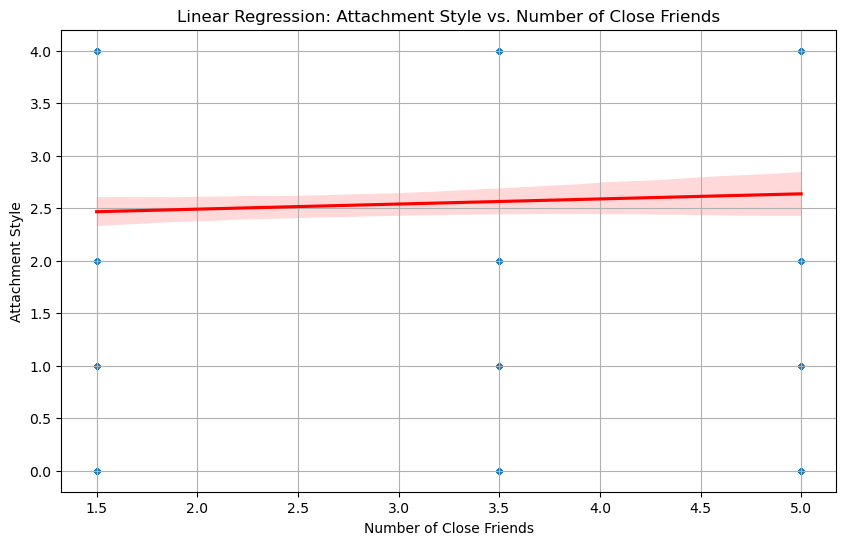

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load the dataset
url = 'https://github.com/pointOfive/stat130chat130/blob/main/CP/CSCS_data_anon.csv?raw=true'
data = pd.read_csv(url, low_memory=False)

# Mapping for attachment style questionnaire
attachment_style_map = {
    'Totally agree': 5,
    'Somewhat agree': 4,
    'Somewhat disagree': 2,
    'Disagree': 1,
    'Totally disagree': 0
}

# Convert the attachment style responses to numeric values
data['attachment_style_num'] = data['PSYCH_attachment_style_questionnaire_secure_confident'].map(attachment_style_map)

# Function to convert close friends string values to numeric
def convert_close_friends(value):
    if pd.isna(value):
        return np.nan
    if 'or more' in value:
        return 5  # Assuming '5 or more' translates to 5
    elif 'Presented but no response' in value:
        return np.nan  # Treating as missing
    else:
        parts = value.split('–')
        return np.mean([int(parts[0]), int(parts[1])]) if len(parts) > 1 else int(parts[0])

# Apply the conversion function to the relevant column
data['close_friends_num'] = data['CONNECTION_social_num_close_friends_grouped'].apply(convert_close_friends)

# Remove rows with missing values in the relevant columns
data_clean = data.dropna(subset=['close_friends_num', 'attachment_style_num'])

# Prepare the model (add a constant to the predictor for the intercept)
X = sm.add_constant(data_clean['close_friends_num'])
y = data_clean['attachment_style_num']

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Check model summary
print(model.summary())

# Plot the linear regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='close_friends_num', y='attachment_style_num', data=data_clean, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Linear Regression: Attachment Style vs. Number of Close Friends')
plt.xlabel('Number of Close Friends')
plt.ylabel('Attachment Style')
plt.grid(True)

# Show the plot
plt.show()


interpretation of results:

Intercept (const): The constant term is 2.3938, with a standard error of 0.124. This means that when close_friends_num is zero, the estimated value of the dependent variable (attachment style score) is 2.3938. Since the p-value for this coefficient is 0.000 (which is well below the common significance threshold of 0.05), the intercept is statistically significant, indicating a reliable estimate for the baseline level of the dependent variable.

Coefficient for close_friends_num: The coefficient is 0.0487, with a standard error of 0.040. This means that for each additional close friend, the dependent variable (attachment style score) is expected to increase by 0.0487 units. However, the p-value for this coefficient is 0.229, which is above the significance level of 0.05. This suggests that the relationship between close_friends_num and the dependent variable is not statistically significant, and you cannot confidently conclude that the number of close friends affects attachment style at this level of analysis.

So... Does the Relationship Decline After a Certain Number of Friends?

Not evident from this model. A linear regression assumes a constant slope and cannot detect non-linear trends (e.g., declines after a certain number of friends). 

talking to Chatgpt has led me to use a polynomial regression model, which has not been taught in class... but I shall show it for fun anyways. The interpretation for this part may be off since I have not learnt about it yet. But from the graph below you can see a slight decrease of the curve after the point x = 3.5, though how reliable this data is, I cannot conclude just yet... would be interesting to do more research on this!

Polynomial regression model

                             OLS Regression Results                             
Dep. Variable:     attachment_style_num   R-squared:                       0.005
Model:                              OLS   Adj. R-squared:                  0.002
Method:                   Least Squares   F-statistic:                     1.828
Date:                  Sun, 24 Nov 2024   Prob (F-statistic):              0.161
Time:                          22:18:23   Log-Likelihood:                -1375.1
No. Observations:                   771   AIC:                             2756.
Df Residuals:                       768   BIC:                             2770.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9664      0.313

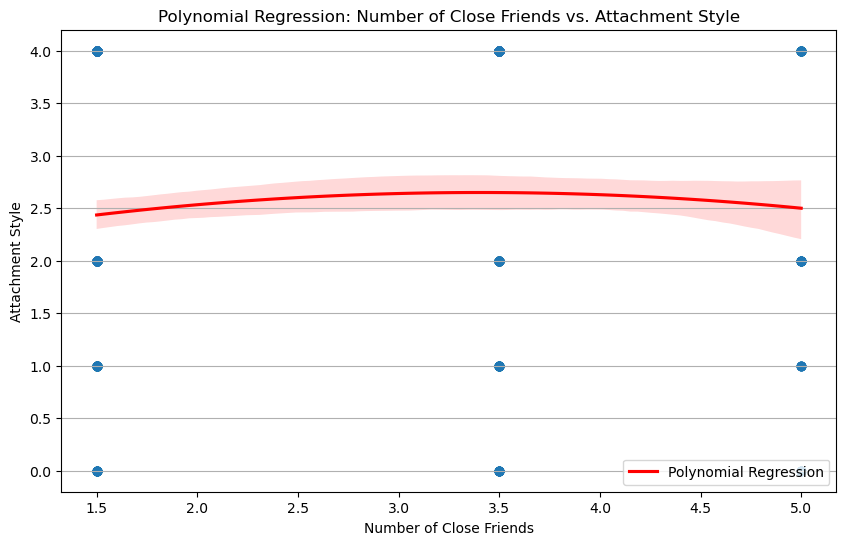

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

# Load the dataset
url = 'https://github.com/pointOfive/stat130chat130/blob/main/CP/CSCS_data_anon.csv?raw=true'
data = pd.read_csv(url, low_memory=False)

# Function to convert close friends string values to numeric
def convert_close_friends(value):
    if pd.isna(value):
        return np.nan
    if 'or more' in value:
        return 5  # Assuming '5 or more' translates to 5
    elif 'Presented but no response' in value:
        return np.nan  # Treating as missing
    else:
        parts = value.split('–')
        return np.mean([int(parts[0]), int(parts[1])]) if len(parts) > 1 else int(parts[0])

# Apply the conversion function to the relevant column
data['close_friends_num'] = data['CONNECTION_social_num_close_friends_grouped'].apply(convert_close_friends)

# Mapping for attachment style questionnaire
attachment_style_map = {
    'Totally agree': 5,
    'Somewhat agree': 4,
    'Somewhat disagree': 2,
    'Disagree': 1,
    'Totally disagree': 0
}

# Convert the attachment style responses to numeric values
data['attachment_style_num'] = data['PSYCH_attachment_style_questionnaire_secure_confident'].map(attachment_style_map)

# Remove rows with missing values in the relevant columns
data_clean = data.dropna(subset=['close_friends_num', 'attachment_style_num'])

# Extract independent and dependent variables
X = data_clean['close_friends_num'].values.reshape(-1, 1)
y = data_clean['attachment_style_num']

# Create polynomial features (degree 2 for quadratic)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Add constant term (intercept) for the regression
X_poly = sm.add_constant(X_poly)

# Fit the polynomial regression model
model_poly = sm.OLS(y, X_poly).fit()

# Print the model summary
print(model_poly.summary())

# Visualization of the polynomial regression curve
plt.figure(figsize=(10, 6))
sns.regplot(
    x='close_friends_num', 
    y='attachment_style_num', 
    data=data_clean, 
    scatter_kws={'alpha': 0.5}, 
    line_kws={'color': 'red', 'label': 'Polynomial Regression'},
    order=2  # Order 2 for quadratic regression
)
plt.title('Polynomial Regression: Number of Close Friends vs. Attachment Style')
plt.xlabel('Number of Close Friends')
plt.ylabel('Attachment Style')
plt.legend()
plt.grid(axis='y')
plt.show()


it seems the R-squared here is 0.005, meaning that  only 0.5% of the variance in the dependent variable (attachment style score) is explained by the model. This is extremely low, suggesting that the independent variables do not explain the data well. This suggests that there may be a weak or no meaningful relationship between the independent variables (x1 and x2) and the dependent variable (attachment_style_num)

moving forward, things to improve in order to establish stronger statistical evidence:

1. Increase sample size
2. Address Missing Data
3. Consider other nonlinear models such as decision trees, random forests, etc models.
4. Regularization: Lasso or Ridge Regression can help by adding penalties to the model